In [3]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
DATA_DIR = '.\data\enhanced'
hairdryer = 'hair_dryer_finished.csv'
microwave = 'microwave_finished.csv'
pacifier = 'pacifier_finished.csv'

In [5]:
pdata = pd.read_csv(os.path.join(DATA_DIR, pacifier))
hdata = pd.read_csv(os.path.join(DATA_DIR, hairdryer))
mdata = pd.read_csv(os.path.join(DATA_DIR, microwave))

pdata = pdata.dropna(axis=0,how='any').drop(pdata.tail(1).index)
pdata.review_date = pd.to_datetime(pdata.review_date, format='%m/%d/%Y')
hdata = hdata.dropna(axis=0,how='any')
hdata.review_date = pd.to_datetime(hdata.review_date, format='%m/%d/%Y')
mdata = mdata.dropna(axis=0,how='any')
mdata.review_date = pd.to_datetime(mdata.review_date, format='%m/%d/%Y')

In [6]:
pdata.sort_values('review_date', inplace=True)
hdata.sort_values('review_date', inplace=True)
mdata.sort_values('review_date', inplace=True)

In [7]:
pdata['year'] = [x.year for x in pdata.review_date]
pdata['quater'] = [int((x.month-1)/3+1) for x in pdata.review_date]
hdata['year'] = [x.year for x in hdata.review_date]
hdata['quater'] = [int((x.month-1)/3+1) for x in hdata.review_date]
mdata['year'] = [x.year for x in mdata.review_date]
mdata['quater'] = [int((x.month-1)/3+1) for x in mdata.review_date]

In [26]:
## socre & plot

def score(sample):
    if(int(sample['total_votes'])==0):
        x = 0
    else:
        x = float(sample['helpful_votes']) / float(sample['total_votes'])
    s = (int(sample['star_rating'])-3 + int(sample['like'])*1.5) / 2
    w1 = 1 + x*sample['tech']
    w2 = 1 + (sample['vine']=='Y')
    z = 0 if s==0 else (sample['verified_purchase']=='Y') / (-s)
    w3 = 1 + z*max([0, s])
    return (w1+w2+w3)*s

def powscore(data):
    seq_mean = []
    seq_std = []
    seq_time = []
    seq_upper = []
    seq_lower = []
    for y in set(data['year']):
        for q in set(data['quater']):
            idx = (data['year']==y)&(data['quater']==q)
            if np.sum(idx)<3:
                continue
            else:
                subset = data[idx]
                subseq = []
                for i in range(subset.shape[0]):
                    subseq.append(score(subset.iloc[i]))
                subseq = np.array(subseq)
                seq_mean.append(subseq.mean())
                seq_std.append(subseq.std())
                seq_upper.append(np.percentile(subseq, 90))
                seq_lower.append(np.percentile(subseq, 10))
                seq_time.append(str(y)[-2:]+'.'+str(q))
    return (seq_mean, seq_std, seq_time, seq_upper, seq_lower, seq_time)

def plotseq(seq_mean, seq_std, seq_time=None, add=None, seq_upper=None, seq_lower=None):
    seq_mean = np.array(seq_mean)
    plt.ylim(np.mean(seq_mean)-2*np.mean(seq_std), np.mean(seq_mean)+2*np.mean(seq_std))
    if seq_time!=None:
       plt.plot(seq_time,seq_mean)
    else:
        plt.plot(seq_mean)
    if add:
        seq_std = np.array(seq_std)
        plt.plot(seq_time,seq_mean+3*seq_std,'green')
        plt.plot(seq_time,seq_mean-3*seq_std,'green')
    if seq_lower!=None:
        plt.plot(seq_time,seq_lower,'green')
    if seq_upper!=None:
        plt.plot(seq_time,seq_upper,'green')

In [84]:
pseq1,pseq2,pseq3,pseq4,pseq5,pseqtime = powscore(pdata)
hseq1,hseq2,hseq3,hseq4,hseq5,hseqtime = powscore(hdata)
mseq1,mseq2,mseq3,mseq4,mseq5,mseqtime = powscore(mdata)

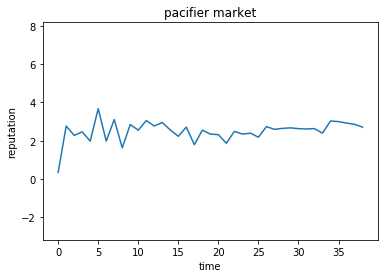

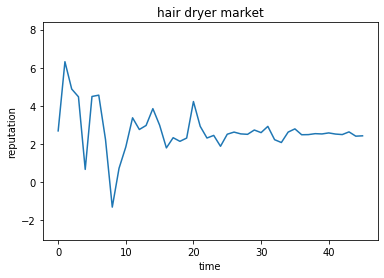

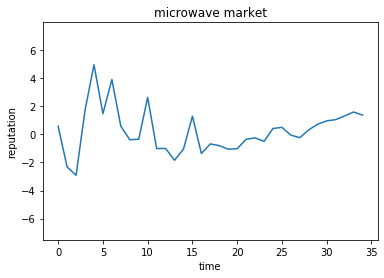

In [85]:
plt.figure()
plotseq(pseq1, pseq2)
plt.title('pacifier market')
plt.xlabel('time')
plt.ylabel('reputation')
plt.savefig('.\pics\pacifier market'+'.jpg')
plt.figure()
plotseq(hseq1, hseq2)
plt.title('hair dryer market')
plt.xlabel('time')
plt.ylabel('reputation')
plt.savefig('.\pics\hair dryer market'+'.jpg')
plt.figure()
plotseq(mseq1, mseq2)
plt.title('microwave market')
plt.xlabel('time')
plt.ylabel('reputation')
plt.savefig('.\pics\microwave market'+'.jpg')

In [101]:
def compic(dataset, name, save=None):
    company = dataset.product_title.value_counts()[-1].index
    for item in company:
        c = dataset[dataset.product_title==item]
        seq1,seq2,seq3,seq4,seq5,seq6 = powscore(c)
        plt.figure()
        plotseq(seq1, seq2)
        plt.title(name+' company: '+item[:15])
        plt.xlabel('time')
        plt.ylabel('reputation')
        if save!=None:
            plt.savefig(os.path.join(save,name+' '+item[:10]+'.jpg'))

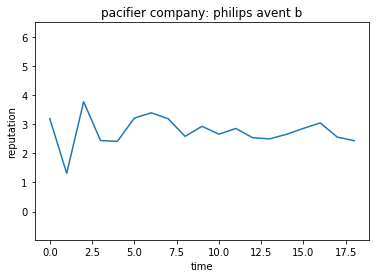

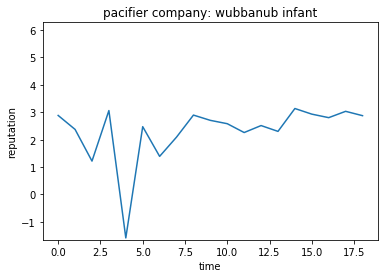

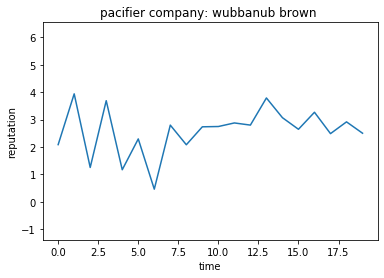

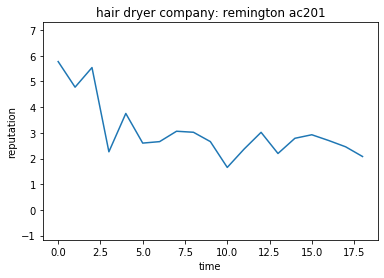

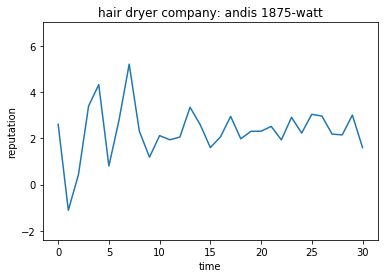

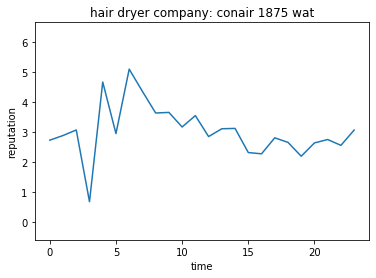

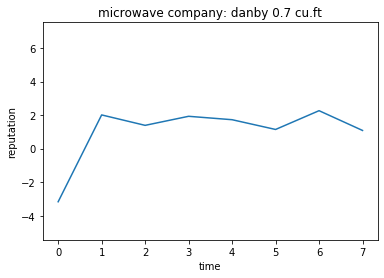

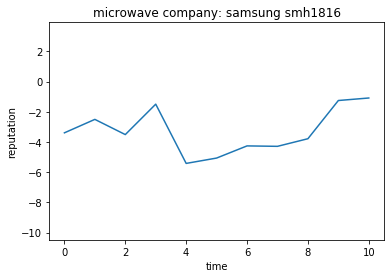

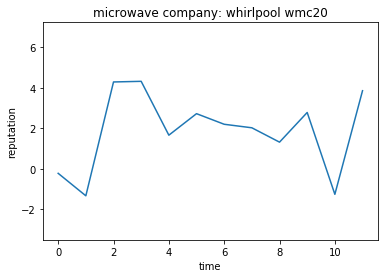

In [102]:
compic(pdata, 'pacifier', save='.\pics')
compic(hdata, 'hair dryer', save='.\pics')
compic(mdata, 'microwave', save='.\pics')

In [68]:
product = hdata.product_title.value_counts().index
product = product[0]
hpdata = hdata[hdata['product_title']==product]

R, RL, RN, RD, SRP, SRN = [],[],[],[],[],[]
timeline = []
for y in set(hpdata['year']):
    for q in set(hpdata['quater']):
        idx = (hpdata['year']==y)&(hpdata['quater']==q)
        if np.sum(idx)<3:
            continue
        
        subset = hpdata[idx]
        
        subseq = []
        for i in range(subset.shape[0]):
            subseq.append(score(subset.iloc[i]))
        subseq = np.array(subseq)
        R.append(subseq.mean())
        timeline.append(str(y)+'Q'+str(q))
    
        n = subset.shape[0]
        nl = np.sum(subset['like']==1)
        nn = np.sum(subset['like']==0)
        nd = np.sum(subset['like']==-1)
        RL.append(nl/n)
        RN.append(nn/n)
        RD.append(nd/n)
        
        ulidx =(subset['like']==0)&(subset['tech']==1)
        udidx =(subset['like']==-1)&(subset['tech']==1)
        nul = np.sum(ulidx)
        nud = np.sum(udidx)
    
        SRP.append(np.sum(subset[ulidx].helpful_votes)/np.sum(subset[ulidx].total_votes))
        SRN.append(np.sum(subset[udidx].helpful_votes)/np.sum(subset[udidx].total_votes))
        
        
temp = pd.DataFrame()
temp['time'] = timeline
temp['R'] = R
temp['RL'] = RL
temp['RN'] = RN
temp['RD'] = RD
temp['SRP'] = SRP
temp['SRN'] = SRN

D:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in longlong_scalars
D:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in longlong_scalars


In [70]:
temp.to_csv('cdata.csv')

In [ ]:
for item in product:
    c = dataset[dataset.product_title==item]
    seq1,seq2,seq3,seq4,seq5,seq6 = powscore(c)
    seq1